In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from datetime import datetime
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [ ]:
epochs = 5
batch_size = 50

In [ ]:
# Each training data point will be length 100-1,
# since the last value in each sequence is the label
sequence_length = 100

In [ ]:
def generate_model():

    METRICS = [
             keras.metrics.TruePositives(name = 'tp'),
             keras.metrics.FalsePositives(name = 'fp'),
             keras.metrics.TrueNegatives(name = 'tn'),
             keras.metrics.FalsePositives(name = 'fn'),
             keras.metrics.BinaryAccuracy(name = 'accuracy'),
             keras.metrics.Precision(name = 'precision'),
             keras.metrics.Recall(name = 'recall'),
             keras.metrics.AUC(name = 'auc'),
             keras.metrics.AUC(name = 'prc', curve = 'PR')
    ]
    
    model = keras.Sequential([
    keras.layers.LSTM(60, return_sequences=True),          
    keras.layers.LSTM(60, return_sequences=True),               
    keras.layers.TimeDistributed(keras.layers.Dense(60, activation = 'sigmoid')),
    keras.layers.TimeDistributed(keras.layers.Dropout(.15)),
    keras.layers.TimeDistributed(keras.layers.Dense(1))
    ])

    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate=1e-3),
        loss = keras.losses.BinaryCrossentropy())
    
    return model

In [ ]:
def normalize(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean

In [ ]:
def prepare_data(data, train_start, train_end, test_start, test_end):
    print("Length of Data", len(data))

    # training data
    print("Creating training data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Training data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)
    X_train = train[:, :-1]
    y_train = train[:, -1]

    # test data
    print("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)
    result, result_mean = normalize(result)

    print("Test data shape  : {}".format(result.shape))

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(y_train))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test

In [ ]:
def run(model=None, data=None):
    global_start_time = time.time()

    print('Loading data... ')
    data_b = pd.read_csv('iot-util.csv',
                         parse_dates=[0], infer_datetime_format=True)
    data = data_b['cpu'].to_numpy()

    # train on first 500 samples and test on last 160 samples (test set has anomaly)
    X_train, y_train, X_test, y_test = prepare_data(data, 0, 600, 400, 660)

    # print('shape of training data')
    # print(np.squeeze(X_train).shape)
    # print(y_train.shape)


    if model is None:
        model = generate_model()

    try:
        print("Training...")
        model.fit(
                X_train, y_train,
                batch_size=batch_size, epochs=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test, verbose=1)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print('Training duration:{}'.format(time.time() - global_start_time))
        return model, y_test, 0

  

    try:
        plt.figure(figsize=(20,8))
        plt.plot(y_test[:len(y_test)], 'b', label='Observed')
        plt.plot(predicted[:len(y_test)], 'g', label='Predicted')
        plt.plot(((y_test - predicted[:len(y_test)]) ** 2), 'r', label='Root-mean-square deviation')
        plt.legend()
        plt.show()
    except Exception as e:
        print("plotting exception")
        print(str(e))
    print('Training duration:{}'.format(time.time() - global_start_time))

    return model, y_test, predicted

Loading data... 
Length of Data 660
Creating training data...
Training data shape  :  (500, 100)
Creating test data...
Test data shape  : (160, 100)
Shape X_train (500, 99)
Shape X_test (500,)
Training...
Epoch 1/5
10/10 [==============================] - 5s 172ms/step - loss: 1.7204 - val_loss: 3.3925
Epoch 2/5
10/10 [==============================] - 1s 92ms/step - loss: 1.7176 - val_loss: 3.3925
Epoch 3/5
10/10 [==============================] - 1s 92ms/step - loss: 1.6107 - val_loss: 2.6147
Epoch 4/5
10/10 [==============================] - 1s 93ms/step - loss: 1.4012 - val_loss: 2.3344
Epoch 5/5
10/10 [==============================] - 1s 89ms/step - loss: 1.3274 - val_loss: 2.5772
Predicting...
5/5 [==============================] - 1s 23ms/step
Reshaping predicted


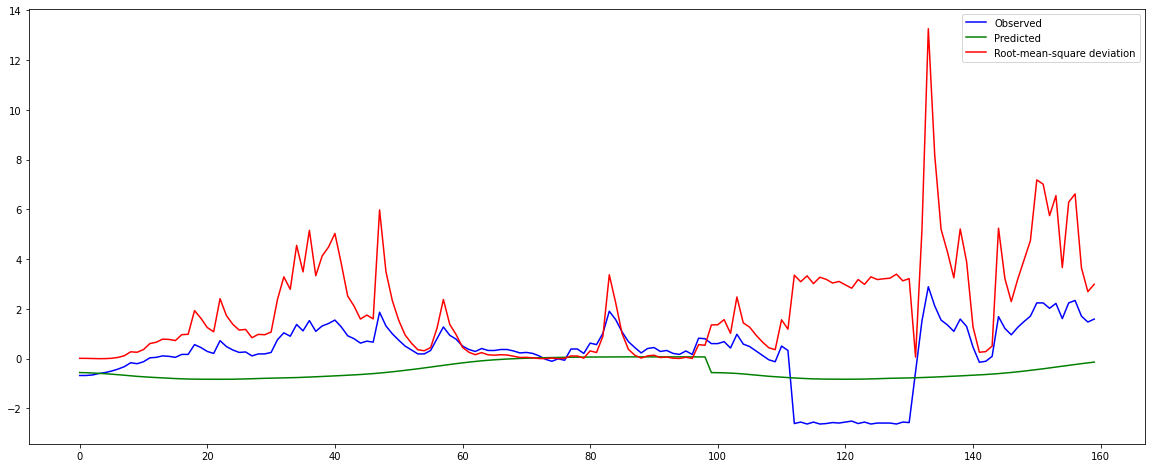

Training duration:9.849144458770752


In [ ]:
model, y_test, predicted = run()

In [ ]:
#anomaly threshold of 5 chosen based on empirical analyses
start_time = 0
threshold = 5
# print(len(y_test))
for i in range(0, len(y_test)-1):
    if ((y_test[i] - predicted[i]) ** 2) > threshold:
        print("Anomaly at time", start_time+i, "RMSE value:", (y_test[i] - predicted[i]) ** 2)
    i = i+1

Anomaly at time 36 RMSE value: 5.159978686864148
Anomaly at time 40 RMSE value: 5.035687304263882
Anomaly at time 47 RMSE value: 5.981580526623101
Anomaly at time 132 RMSE value: 5.1621985352869775
Anomaly at time 133 RMSE value: 13.267593876768586
Anomaly at time 134 RMSE value: 8.196909503230346
Anomaly at time 135 RMSE value: 5.199021029232294
Anomaly at time 138 RMSE value: 5.2143913165004445
Anomaly at time 144 RMSE value: 5.246032752499407
Anomaly at time 150 RMSE value: 7.1869429704830585
Anomaly at time 151 RMSE value: 7.015279040055734
Anomaly at time 152 RMSE value: 5.750991449912182
Anomaly at time 153 RMSE value: 6.55416406514161
Anomaly at time 155 RMSE value: 6.294981562406394
Anomaly at time 156 RMSE value: 6.6233658176629895
